In [41]:
#Importing required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import collections as c
import statsmodels.api as sm
from haversine import haversine
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

In [3]:
#Loading the data
data = pd.read_csv("C:/Users/DEEPANK/OneDrive/Documents/PES University/Sem 3/Data Science/metro-bike-data.csv")
print("No. of columns in the dataset: ",data.shape[1])
print("No. of rows in the dataset: ",data.shape[0])

No. of columns in the dataset:  22
No. of rows in the dataset:  132427


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 22 columns):
Trip ID                              132427 non-null int64
Duration                             132427 non-null int64
Start Time                           132427 non-null object
End Time                             132427 non-null object
Starting Station ID                  132408 non-null float64
Starting Station Latitude            132379 non-null float64
Starting Station Longitude           132379 non-null float64
Ending Station ID                    132331 non-null float64
Ending Station Latitude              131376 non-null float64
Ending Station Longitude             131376 non-null float64
Bike ID                              132417 non-null float64
Plan Duration                        131661 non-null float64
Trip Route Category                  132427 non-null object
Passholder Type                      132427 non-null object
Starting Lat-Long                    98622 

In [4]:
data.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,...,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long,Neighborhood Councils (Certified),Council Districts,Zip Codes,LA Specific Plans,Precinct Boundaries,Census Tracts
0,18222186,15060,2017-01-19T17:05:00.000,2017-01-19T21:16:00.000,3031.0,34.044701,-118.252441,3000.0,NaN,NaN,...,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9518671,77160,2016-10-09T14:37:00.000,2016-10-10T12:03:00.000,NaN,NaN,NaN,3000.0,NaN,NaN,...,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20444932,86400,2017-02-18T10:15:00.000,2017-02-20T15:20:00.000,3026.0,34.063179,-118.245880,3000.0,NaN,NaN,...,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20905031,18840,2017-02-27T12:26:00.000,2017-02-27T17:40:00.000,3023.0,34.050911,-118.240967,3000.0,NaN,NaN,...,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21031476,86400,2017-02-27T20:26:00.000,2017-03-01T09:49:00.000,3008.0,34.046612,-118.262733,3000.0,NaN,NaN,...,One Way,Flex Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_na = (data.isnull().sum()*100)/len(data)
print("% of missing data in each feature:")
data_na.sort_values(ascending=False)

% of missing data in each feature:


LA Specific Plans                    88.066633
Zip Codes                            25.551436
Council Districts                    25.551436
Neighborhood Councils (Certified)    25.551436
Starting Lat-Long                    25.527272
Census Tracts                         0.829891
Precinct Boundaries                   0.829891
Ending Lat-Long                       0.793645
Ending Station Longitude              0.793645
Ending Station Latitude               0.793645
Plan Duration                         0.578432
Ending Station ID                     0.072493
Starting Station Longitude            0.036246
Starting Station Latitude             0.036246
Starting Station ID                   0.014348
Bike ID                               0.007551
Trip Route Category                   0.000000
Passholder Type                       0.000000
End Time                              0.000000
Start Time                            0.000000
Duration                              0.000000
Trip ID      

In [51]:
data.drop(["LA Specific Plans"], axis = 1, inplace = True)

In [7]:
# Query 1 - Finding the busiest route 
data['Ending Station ID'].replace(regex=True,inplace=True,to_replace=r'[^0-9]+',value=r'')
data['Starting Station ID'].replace(regex=True,inplace=True,to_replace=r'[^0-9]+',value=r'')

In [8]:
l1 = data[data['Ending Station ID'].isna()].index.tolist()
l2 = data[data['Starting Station ID'].isna()].index.tolist()
df_es = data['Ending Station ID'].dropna()
df_es = df_es.drop(df_es.index[l2])
df_ss = data['Starting Station ID'].dropna()
df_ss = df_ss.drop(df_ss.index[l1])
concat = df_es.map(str) + df_ss.map(str)

In [9]:
concat.value_counts().head()

3014.03030.0    931
3030.03014.0    677
3005.03031.0    610
3048.03048.0    568
3031.03005.0    513
dtype: int64

In [10]:
# Query 2 - Finding the busiest stations
df_es.value_counts().head() # Destination Station

3005.0    6261
3031.0    5515
3014.0    5378
3042.0    5294
3069.0    5075
Name: Ending Station ID, dtype: int64

In [11]:
df_ss.value_counts().head() # Starting Station

3069.0    5135
3030.0    5059
3005.0    4879
3064.0    4648
3031.0    4627
Name: Starting Station ID, dtype: int64

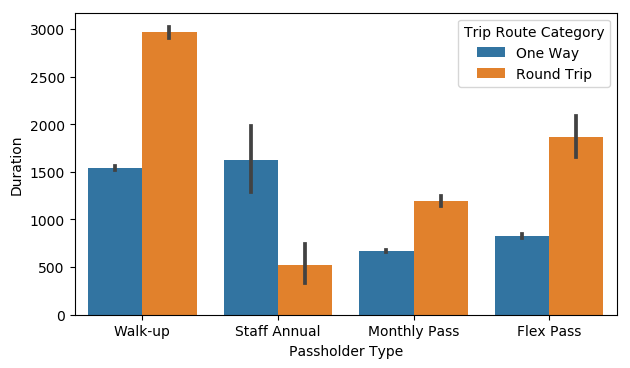

In [19]:
# Query 3 - Comparison between Trip Route Category and Passholder Type
data['Trip Route Category'].drop(drop,inplace=True)
ax = sns.barplot(x="Passholder Type", y="Duration",hue="Trip Route Category", data=data)

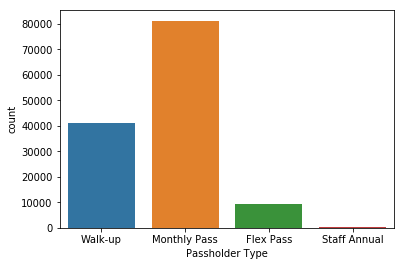

In [13]:
# Query 4 - Which passholder type has done more trips
sns.countplot(data = data, x='Passholder Type')

In [14]:
# Query 5 - Relation between Passholder type and Duration
data['Duration'].describe()

count    132427.000000
mean       1556.553875
std        5821.734908
min          60.000000
25%         360.000000
50%         600.000000
75%        1080.000000
max       86400.000000
Name: Duration, dtype: float64

In [15]:
#Finding Outliers
z = np.abs(stats.zscore(data['Duration']))
lz = np.where(z>3)

In [16]:
#Removing Outliers
drop = []
for i in range(0,len(lz[0])):
    drop.append(lz[0][i])
data['Duration'].drop(drop,inplace=True)
data['Passholder Type'].drop(drop,inplace=True)

[Text(0,0.5,'Frequency'), Text(0.5,1,'Frequency Histogram')]

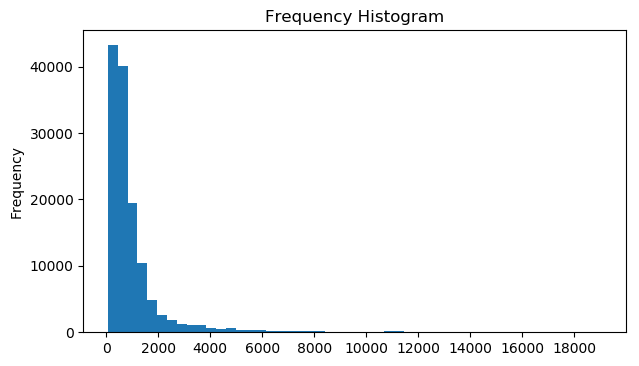

In [17]:
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':100})
plt.hist(data['Duration'], bins=50)
plt.xticks(range(0,20000,2000))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')

c:\users\deepank\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


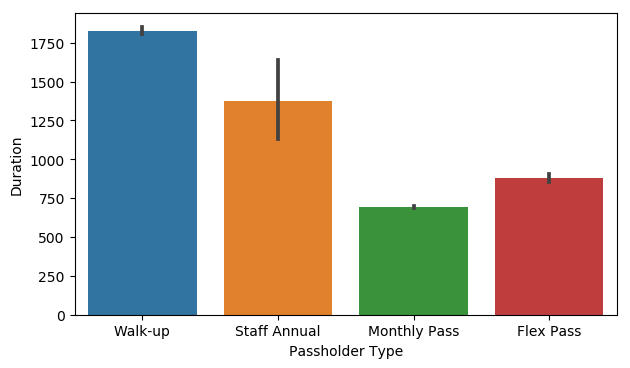

In [18]:
sns.barplot(data=data, x = 'Passholder Type', y = 'Duration')

In [20]:
# Query 6 - Monthly usage of bikes
end_time = []
for i in range(0, len(data['End Time'])):
    date = np.datetime64(data['End Time'][i])
    end_time.append(date.astype(object).month)

In [21]:
end_time.sort()
c.Counter(end_time)

Counter({1: 10353,
         2: 9530,
         3: 13901,
         4: 9,
         7: 11409,
         8: 24167,
         9: 19855,
         10: 18158,
         11: 14434,
         12: 10611})

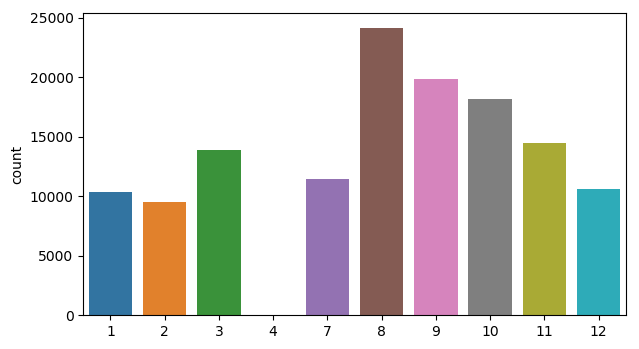

In [22]:
sns.countplot(x=end_time)

In [23]:
#Query 7 - Finding the busiest bike
mins = data['Duration']/60
lb = data[data['Bike ID'].isna()].index.tolist()
mins = mins.drop(mins.index[lb])
b_id = data['Bike ID'].dropna()
b_id = b_id.drop(b_id.index[drop])

In [24]:
dct = {}
count, vl = [],[]
key = list(b_id)
value = list(mins)
for i in range(0,len(key)):
    if key[i] not in dct:
        dct[key[i]]=value[i]
    else:
        val = dct[key[i]]+value[i]
        dct[key[i]]=val

for key, dval in dct.items():
    if dval > 4500:
        count.append(key)
        vl.append(round(dval/60))

In [25]:
dt = list(zip(count,vl))
dt

[(6307.0, 75),
 (6644.0, 77),
 (5860.0, 78),
 (6398.0, 82),
 (6527.0, 76),
 (5999.0, 75),
 (6162.0, 76),
 (6618.0, 81),
 (6435.0, 77),
 (6075.0, 75),
 (6647.0, 82),
 (5839.0, 77),
 (6413.0, 83),
 (4727.0, 78),
 (6424.0, 78),
 (6249.0, 83),
 (6452.0, 80)]

In [5]:
# Query 8 - Calculating distance based on coordinates
ds=[]
slat, slong, elat, elong = data['Starting Station Latitude'], data['Starting Station Longitude'], data['Ending Station Latitude'], data['Ending Station Longitude']
for i in range(0, len(slat)):
    ds.append(haversine((slat[i],slong[i]),(elat[i],elong[i])))

In [6]:
data['Distance'] = pd.DataFrame(ds)
data['Distance'].describe()

count    131336.000000
mean          4.895575
std         219.406902
min           0.000000
25%           0.578460
50%           0.960547
75%           1.456465
max       12576.867398
Name: Distance, dtype: float64

In [7]:
dist = np.array(data['Distance']).tolist()
dist = pd.DataFrame(dist)
dl = dist[dist[0]>12000].index.tolist()
dist = dist.drop(dist.index[dl])
dist = dist.replace(np.nan,np.mean(dist))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9D1E35B38>]],
      dtype=object)

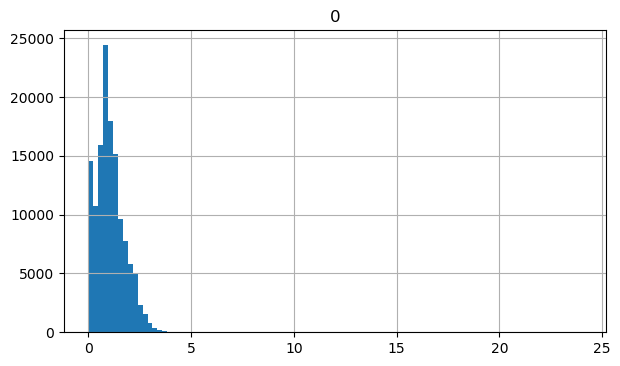

In [29]:
dist.hist(bins=100,range=(0,24))

In [30]:
# Query 9 - Linear Regression between Distance and Price
data['Price'] = data.apply(lambda row: (row.Distance)*1.5 + (row.Duration/3600)*0.5, axis=1)
price = np.array(data['Price']).tolist()
price = pd.DataFrame(price)
price = price.drop(price.index[dl])
price = price.replace(np.nan,np.mean(price))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9CE2C42B0>]],
      dtype=object)

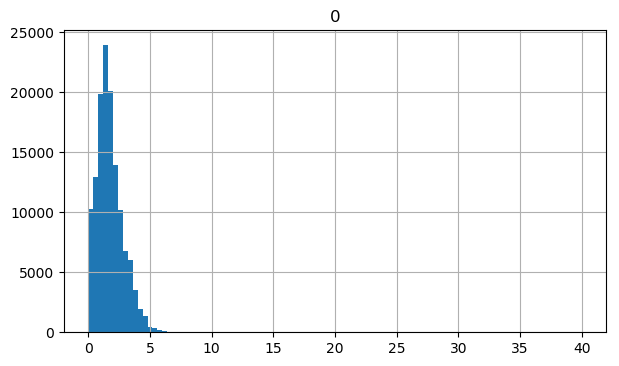

In [31]:
price.hist(bins=100,range=(0,40))

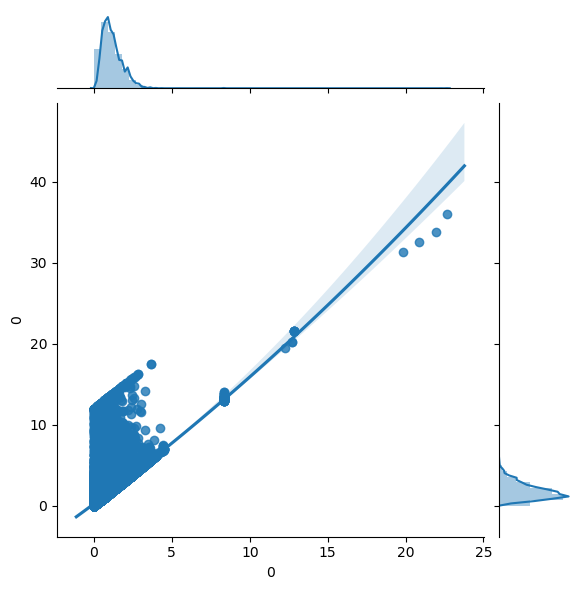

In [33]:
g = sns.JointGrid(x=dist[0], y=price[0]) 
g.plot_joint(sns.regplot, order=2) 
g.plot_marginals(sns.distplot)

In [38]:
X = np.array(dist[0]).reshape(-1, 1) 
y = np.array(price[0]).reshape(-1, 1) 
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

# Splitting the data into training and testing data 
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

0.7318867144207362


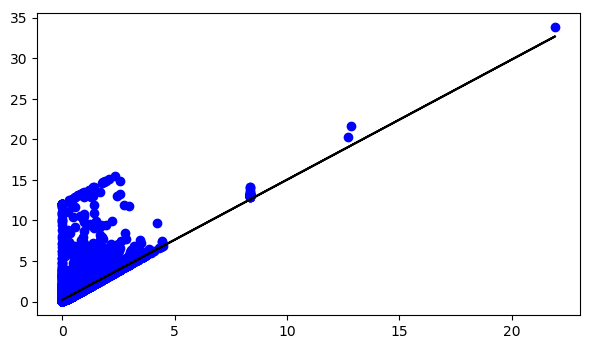

In [37]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
plt.show() 

In [39]:
# Query 10 - Logistic Regression
pt = data['Passholder Type']
pt = pt.drop(pt.index[dl])
df = pd.DataFrame()
df['Passholder Type'] = pt
df['Distance'] = dist
df['Price'] = price

In [40]:
df['Codes']=pt
nums = {'Codes': {'Walk-up':1, 'Monthly Pass':2, 'Flex Pass':3, 'Staff Annual':4}}
df.replace(nums, inplace=True)

In [41]:
x = df.iloc[:, [1, 2]].values 
y = df.iloc[:, 3].values 
xtrain, xtest, ytrain, ytest = train_test_split( 
		x, y, test_size = 0.25, random_state = 0)

In [42]:
sc_x = StandardScaler() 
xtrain = sc_x.fit_transform(xtrain) 
xtest = sc_x.transform(xtest) 
print (xtrain[0:10, :])

[[ 0.71702845  0.53989044]
 [ 0.10509752  0.007612  ]
 [-1.47524934 -1.1328264 ]
 [-0.36589904 -0.4422257 ]
 [-0.36589904 -0.4422257 ]
 [ 0.57455968  0.40927477]
 [ 0.12606486  0.05930744]
 [ 0.46264242  0.35876558]
 [-0.73470341 -0.5756633 ]
 [-1.47524934 -1.19974107]]


In [43]:
classifier = LogisticRegression(random_state = 0) 
classifier.fit(xtrain, ytrain)
y_pred = classifier.predict(xtest)

In [44]:
cm = confusion_matrix(ytest, y_pred) 
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[ 1835  8505     0     0]
 [  392 19879     0     0]
 [  101  2280     0     0]
 [    4   101     0     0]]


In [45]:
print ("Accuracy : ", accuracy_score(ytest, y_pred))

Accuracy :  0.6560715472701454


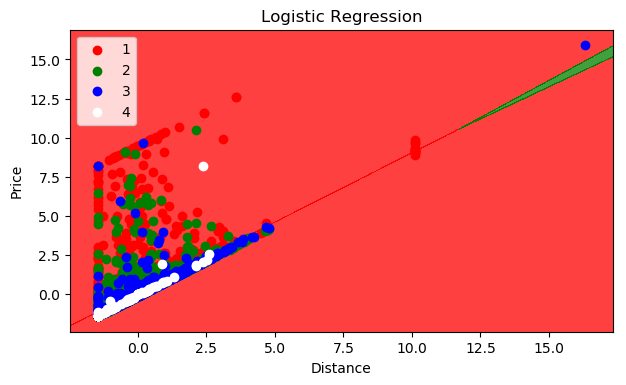

In [46]:
X_set, y_set = xtest, ytest 
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, 
							stop = X_set[:, 0].max() + 1, step = 0.01), 
					np.arange(start = X_set[:, 1].min() - 1, 
							stop = X_set[:, 1].max() + 1, step = 0.01)) 

plt.contourf(X1, X2, classifier.predict( 
			np.array([X1.ravel(), X2.ravel()]).T).reshape( 
			X1.shape), alpha = 0.75, cmap = ListedColormap(('red', 'green'))) 

plt.xlim(X1.min(), X1.max()) 
plt.ylim(X2.min(), X2.max()) 

for i, j in enumerate(np.unique(y_set)): 
	plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
				c = ListedColormap(('red', 'green','blue','white'))(i), label = j) 
	
plt.title('Logistic Regression') 
plt.xlabel('Distance') 
plt.ylabel('Price') 
plt.legend() 
plt.show()

In [8]:
# Query 11 - Hypothesis Testing
# Null Hypothesis: LA Metro Bike Share Service believe that 4% of their users ride the bike more than 
# 3.5 m/s(assume this as more of a threshold value).
# Alternate Hypothesis: More than 4% of the users ride the bike greater than the threshold speed(claimed by LAPD, assume).

data['Speed'] = (data['Distance']*1000)/(data['Duration'])
data['Speed'].drop(data['Distance'].index[dl],inplace=True)
data['Speed'].dropna(inplace=True)

In [84]:
phat = len(data['Speed'][data['Speed']>3.5])/len(data['Speed'])
pnull = 0.04
n = len(data['Speed'])
sm.stats.proportions_ztest(phat * n, n, pnull, alternative = 'larger')

(-2.284706730348255, 0.9888349851366599)